In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
%matplotlib inline

/Applications/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Applications/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
train = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")

In [3]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 39.2+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# ### Populate missing ages  using RandomForestClassifier
# def setMissingAges(df):
    
#     # Grab all the features that can be included in a Random Forest Regressor
#     age_df = df[['Age','Fare', 'Parch', 'SibSp','Pclass']]

#     # Split into sets with known and unknown Age values
#     knownAge = age_df.loc[ (df.Age.notnull()) ]
#     unknownAge = age_df.loc[ (df.Age.isnull()) ]
    
#     # All age values are stored in a target array
#     y = knownAge.pop('Age').values
  
#     # All the other values are stored in the feature array
#     X = knownAge.values
    
#     # Create and fit a model
#     rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
#     rtr.fit(X, y)
    
#     # Use the fitted model to predict the missing values
#     predictedAges = rtr.predict(unknownAge.values[:, 1::])
    
#     # Assign those predictions to the full data set
#     df.loc[ (df.Age.isnull()), 'Age' ] = predictedAges 
    
#     return df

In [6]:
train.Name[:10]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
5                                     Moran, Mr. James
6                              McCarthy, Mr. Timothy J
7                       Palsson, Master. Gosta Leonard
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                  Nasser, Mrs. Nicholas (Adele Achem)
Name: Name, dtype: object

In [7]:
# df = setMissingAges(train)
# df_train = df.copy()
# df_test  = setMissingAges(test)

## Clean the Data

In [8]:
print train[train['Survived']==1]["Age"].mean(), \
train[train['Survived']==0]["Age"].mean(), \
test.Age.mean()

28.3436896552 30.6261792453 30.2725903614


In [9]:
def clean_data(titanic):

    titanic = titanic.copy()
    
#     titanic["Age"] = titanic["Age"].fillna(titanic["Age"].median())
    titanic["Fare"] = titanic["Fare"].fillna(titanic["Fare"].median())
    
    titanic.loc[titanic["Sex"] == "male", "Sex"] = -1
    titanic.loc[titanic["Sex"] == "female", "Sex"] = 1
    
    titanic["Embarked"] = titanic["Embarked"].fillna("S")
    
    titanic['Title'] = titanic['Name'].apply(lambda x: x.split(',')[1].split()[0])

    d = {'Mr.':'Mr', 'Mrs.':'Mrs', 'Miss.':'Miss', 'Master.':'Master', 'Don.':'Mr', 'Rev.':'Mr', 'Dr.':'Dr', 'Mme.':'Mrs',
       'Ms.':'Miss', 'Major.':'Mr', 'Lady.':'Miss', 'Sir.':'Mr', 'Mlle.':'Miss', 'Col.':'Mr', 'Capt.':'Mr', 'the':'Mr',
       'Jonkheer.':'Mr', 'Dona.':'Mrs'}

    titanic['Title'].replace(d, inplace =True)
    
    colnames = ['Title', 'Embarked']
    for colname in colnames:
        titanic[colname] = pd.Categorical(titanic[colname]).codes

    # Grab all the features that can be included in a Random Forest Regressor
    age_titanic = titanic[['Age','Fare', 'Parch', 'SibSp','Pclass']]

    # Split into sets with known and unknown Age values
    knownAge = age_titanic.loc[ (titanic.Age.notnull()) ]
    unknownAge = age_titanic.loc[ (titanic.Age.isnull()) ]
    
    # All age values are stored in a target array
    y = knownAge.pop('Age').values
  
    # All the other values are stored in the feature array
    X = knownAge.values
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(unknownAge.values[:, 1::])
    
    # Assign those predictions to the full data set
    titanic.loc[ (titanic.Age.isnull()), 'Age' ] = predictedAges 
    
    
    # StandardScaler will subtract the mean from each value then scale to the unit variance
#     scaler = StandardScaler()
#     titanic['Age_scaled'] = scaler.fit_transform(titanic['Age'])
#     titanic['Fare_scaled'] = scaler.fit_transform(titanic['Fare'])
    
    titanic.Age = titanic.Age/titanic.Age.max()
    titanic.Fare = titanic.Fare/titanic.Fare.max()

#     d = {'Mr.':28, 'Mrs.':80, 'Miss.':50, 'Master.':28, 'Don.':40, 'Rev.':60, 'Dr.':60, 'Mme.':80,
#            'Ms.':50, 'Major.':60, 'Lady.':70, 'Sir.':40, 'Mlle.':50, 'Col.':60, 'Capt.':60, 'the':28,
#            'Jonkheer.':28, 'Dona.':70}
#     titanic['Title'].replace(d, inplace =True)

    titanic['AgeSex'] = titanic.Age * titanic.Sex
    titanic['AgeSexFare'] = titanic.Age * titanic.Sex * titanic.Fare
    titanic['TitleFare'] = titanic['Title'] * titanic.Fare * titanic.Sex
#     titanic['PclassSq'] = titanic.Pclass ** 2
#     titanic['SexFare'] = titanic.Sex * titanic.Fare
    titanic["FamilySize"] = titanic['Parch'] + titanic['SibSp']


#     titanic.loc[(titanic["Sex"] == "female") , "Age"] = \
#         titanic.loc[(titanic["Sex"] == "female") , "Age"].fillna(28.34)
#     titanic.loc[(titanic["Sex"] == "male") , "Age"] = \
#         titanic.loc[(titanic["Sex"] == "male") , "Age"].fillna(30.62)
#         (titanic[titanic['Survived']==0]["Age"].mean())    
    
#     titanic.loc[titanic["Embarked"] == "S", "Embarked"] = 1
#     titanic.loc[titanic["Embarked"] == "C", "Embarked"] = 2
#     titanic.loc[titanic["Embarked"] == "Q", "Embarked"] = 3
    
    titanic.drop(titanic[['Name', 'Ticket', 'Cabin',
                          'Age',
                          'Sex',
                          'Fare',
                          'SibSp',
                          'Parch',
                          'Title'
                         ]], axis = 1, inplace=True)
    
    return titanic

In [10]:
# train = train[train.Age > 0]
# train.info()

In [11]:
df.info()

NameError: name 'df' is not defined

In [12]:
df = clean_data(train)
df_train = df.copy()
df_train.drop('PassengerId', axis=1, inplace=True)
df_test  = clean_data(test)

In [13]:
y = df_train.pop('Survived').values
X = df_train.values
X_test = df_test.values

## Exploring the Data

In [14]:
df_train.describe()

,Pclass,Embarked,FamilySize
count,891.000000,891.000000,891.000000
mean,2.308642,1.536476,0.904602
std,0.836071,0.791503,1.613459
min,1.000000,0.000000,0.000000
25%,2.000000,1.000000,0.000000
50%,3.000000,2.000000,0.000000
75%,3.000000,2.000000,1.000000
max,3.000000,2.000000,10.000000


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 6 columns):
Pclass        891 non-null int64
Embarked      891 non-null int8
AgeSex        891 non-null object
AgeSexFare    891 non-null object
TitleFare     891 non-null object
FamilySize    891 non-null int64
dtypes: int64(2), int8(1), object(3)
memory usage: 42.6+ KB


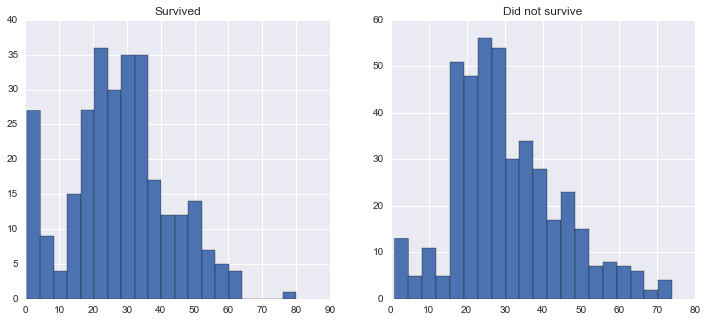

In [17]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
train[train['Survived']==1]["Age"].hist(bins=20, label='survived')
plt.title('Survived')
plt.subplot(1,2,2)
train[train['Survived']==0]["Age"].hist(bins=20)
plt.title('Did not survive')

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891,446.000000,257.353842,1,223.5,446,668.5,891
Survived,891,0.383838,0.486592,0,0.0,0,1.0,1
Pclass,891,2.308642,0.836071,1,2.0,3,3.0,3
Embarked,891,1.536476,0.791503,0,1.0,2,2.0,2
FamilySize,891,0.904602,1.613459,0,0.0,0,1.0,10


In [19]:
df.head()

,PassengerId,Survived,Pclass,Embarked,AgeSex,AgeSexFare,TitleFare,FamilySize
0,1,0,3,2,-0.275,-0.00389154,-0.0424532,1
1,2,1,1,0,0.475,0.0660895,0.556543,1
2,3,1,3,2,0.325,0.00502729,0.0309371,0
3,4,1,1,2,0.4375,0.0453444,0.414577,1
4,5,0,3,2,-0.4375,-0.00687424,-0.0471377,0


## Random Forest

In [20]:
rf = RandomForestClassifier(40)
rf.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [21]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([2, 3, 4, 0, 5, 1])

In [22]:
df_train.columns[feat_rank]

Index([u'AgeSex', u'AgeSexFare', u'TitleFare', u'Pclass', u'FamilySize',
       u'Embarked'],
      dtype='object')

In [23]:
df_features = pd.DataFrame(rf.feature_importances_,df_train.columns, columns = ['feature_value'])

In [24]:
df_features.sort_values('feature_value', ascending=False)

,feature_value
AgeSex,0.319104
AgeSexFare,0.277367
TitleFare,0.241745
Pclass,0.073318
FamilySize,0.063241
Embarked,0.025225


In [25]:
features = [df_train.columns[feat_rank][x] for x in range(6)]
features

['AgeSex', 'AgeSexFare', 'TitleFare', 'Pclass', 'FamilySize', 'Embarked']

In [26]:
# def crossValidate(features, target, classifier, k_fold, r_state=None):

#     k_fold_indices = KFold(len(features), n_folds=k_fold, shuffle=True, random_state=r_state)
    
#     k_score_total = 0
#     for train_indices, test_indices in k_fold_indices :
#         model = classifier.fit(features[train_indices], target[train_indices])
#         k_score = model.score(features[test_indices], target[test_indices])
#         k_score_total = k_score_total + k_score
#     return k_score_total/k_fold

In [27]:
# results = []
# for x in range (10,50,10):
#     for i in range(2,6):
#         for j in range(2,6):
#             results.append((crossValidate(X, y, RandomForestClassifier(x, min_samples_split=i, 
#                                                                        min_samples_leaf=j), 10, 0), x, i, j))

# max(results)

In [28]:
# sorted(results, reverse=True)[:5]

In [29]:
model = RandomForestClassifier(
#     random_state=1,
      n_estimators=100,
      n_jobs = -1,
#     min_samples_split=4,
#     min_samples_leaf=2
)

scores = cross_val_score(model, df[features], df['Survived'], cv=10)

print 'mean:', (scores.mean())

mean: 0.82047071842


Feature ranking:
1. feature 2 (0.326597)
2. feature 3 (0.254862)
3. feature 4 (0.247052)
4. feature 0 (0.084268)
5. feature 5 (0.062888)
6. feature 1 (0.024332)


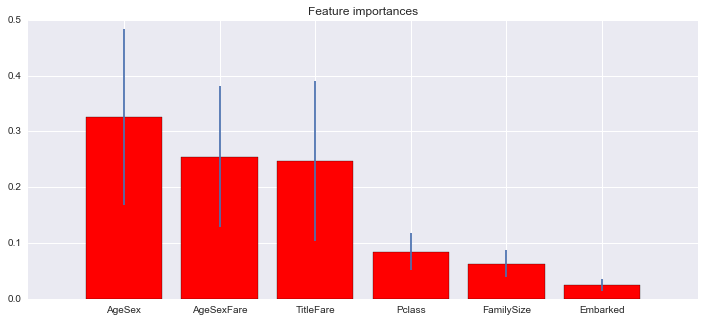

In [30]:
model.fit(X, y)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(12,5))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), df_train.columns[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

In [32]:
features = [df_train.columns[indices][x] for x in range(6)]
features

['AgeSex', 'AgeSexFare', 'TitleFare', 'Pclass', 'FamilySize', 'Embarked']

In [33]:
# features = ['AgeSex',
#  'AgeSexFare',
#  'TitleFare',
#  'Fare',
# #  'Sex',
# #  'Age',
#  'Pclass',
#  'FamilySize']

In [34]:
X = df_train[features].values
X

array([[-0.275, -0.003891540829607214, -0.042453172686624144, 3, 1, 2],
       [0.475, 0.06608947430675433, 0.5565429415305627, 1, 1, 0],
       [0.325, 0.0050272851908499455, 0.030937139635999665, 3, 0, 2],
       ..., 
       [0.2108729910714287, 0.009651941838616661, 0.09154270340242172, 3,
        3, 2],
       [-0.325, -0.0190307325836591, -0.17566830077223783, 1, 0, 0],
       [-0.4, -0.006050797026599304, -0.04538097769949478, 3, 0, 1]], dtype=object)

In [35]:
# rf_param_grid = {'max_depth': [3, None],
#                 'max_features': ['sqrt', 'log2', None],
#                 'min_samples_split': [1, 2, 4],
#                 'min_samples_leaf': [1, 2, 4],
#                 'bootstrap': [True, False],
#                 'n_estimators': [10, 20, 40],
#                 'random_state': [1]}

# rf_gridsearch = GridSearchCV(RandomForestClassifier(),
#                RandomForestClassifierssifierssifierssifier rf_param_grid,
#                              n_jobs=-1,
#                              verbose=True,
#                              scoring='accuracy')
# rf_gridsearch.fit(X, y)

# print "best parameters:", rf_gridsearch.best_params_

# best_rf_model = rf_gridsearch.best_estimator_

In [36]:
def create_submission(model, train, test, features, filename):

    model.fit(train[features], train['Survived'])
    predictions = model.predict(test[features])

    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [37]:
from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint

from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build a classifier
clf = RandomForestClassifier()


# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(1, 6),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              'n_estimators': [10, 40, 50, 60],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=-1)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.grid_scores_)

# use a full grid over all parameters
param_grid = {'max_depth': [3, None],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_split': [1, 2, 4],
              'min_samples_leaf': [1, 2, 4],
              'bootstrap': [True, False],
              'n_estimators': [10, 40, 50, 60],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid, n_jobs=-1)
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.grid_scores_)))
report(grid_search.grid_scores_)

RandomizedSearchCV took 6.81 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.837 (std: 0.024)
Parameters: {'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 10, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 2, 'max_depth': None}

Model with rank: 2
Mean validation score: 0.835 (std: 0.013)
Parameters: {'bootstrap': True, 'min_samples_leaf': 3, 'n_estimators': 40, 'min_samples_split': 8, 'criterion': 'entropy', 'max_features': 5, 'max_depth': None}

Model with rank: 3
Mean validation score: 0.829 (std: 0.009)
Parameters: {'bootstrap': True, 'min_samples_leaf': 6, 'n_estimators': 60, 'min_samples_split': 5, 'criterion': 'entropy', 'max_features': 3, 'max_depth': None}

GridSearchCV took 115.28 seconds for 864 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.842 (std: 0.010)
Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 40, 'min_samples_split': 4, 'criterion': 'gini', 'max

In [ ]:
create_submission(RandomForestClassifier(
                        bootstrap= True, 
                        min_samples_leaf= 5, 
                        n_estimators= 50, 
                        min_samples_split= 2, 
                        criterion= 'gini', 
                        max_features= 5, 
                        max_depth= None), \
                        df, df_test, features, "rf_submission.csv")

Parameters: {'bootstrap': True, 'min_samples_leaf': 4, 'n_estimators': 40, 'min_samples_split': 4, 'criterion': 'gini', 'max_features': None, 'max_depth': None}

## Random Forest Results

```
0.79426
['AgeSex', 'AgeSexFare', 'Fare', 'Sex', 'Pclass', 'Age']
create_submission(RandomForestClassifier(
                        bootstrap= True, 
                        min_samples_leaf= 3, 
                        n_estimators= 20, 
                        min_samples_split= 9, 
                        criterion= 'entropy', 
                        max_features= 4, 
                        max_depth= None)

0.78469
['AgeSex', 'AgeSexFare', 'Fare', 'Age', 'Pclass', 'Sex']
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, predictors, "submission.csv")
0.76555
['AgeSex', 'AgeSexFare', 'Fare', 'Age']
create_submission(RandomForestClassifier(50, min_samples_split=4, min_samples_leaf=2), \
                  df, df_test, features, "submission.csv")
```

In [ ]:
trees_accuracy = []
for i in xrange(1,X.shape[1]):
    rf = RandomForestClassifier(50, max_features = i, min_samples_split=4, min_samples_leaf=2)
    rf.fit(X, y)
    trees_accuracy.append(rf.score(X,y))

In [ ]:
plt.plot(range(1, X.shape[1]), trees_accuracy, '-o')

## SVM

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()), 
                     ('svc', SVC(kernel='linear'))])
pipeline.fit(X, y)

In [ ]:
parameters = {'kernel':['linear','rbf'], 
              'C':np.linspace(.001,10,5),'degree':np.linspace(0,10,5)}

gsCV = GridSearchCV(estimator=pipeline.steps[1][1],
                    param_grid=parameters,scoring='accuracy', cv=5)

In [ ]:
X = pipeline.steps[0][1].fit_transform(X)

In [ ]:
gsCV.fit(X,y)

In [ ]:
gsCV.grid_scores_, gsCV.best_params_

mean: 0.78151, std: 0.03323, params: {'C': 25.00075, 'degree': 0.0}

In [ ]:
def svm_submission(model, train, test, features, filename):

    model.fit(train[features], train['Survived'])
    predictions = model.predict(test[features])

    submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": predictions
    })
    
    submission.to_csv(filename, index=False)

In [ ]:
svm_features = [df_train.columns[feat_rank][x] for x in range(8)]
svm_features

In [ ]:
create_submission(Pipeline([('scaler', StandardScaler()),
                    ('svc', SVC(kernel='rbf', C=2.5, degree=2.5))]), \
                  df, df_test, svm_features, "svm_submission.csv")

## Gradient Boosting

In [ ]:
X = df_train
X.head()

In [ ]:
gdb = GradientBoostingClassifier(
                n_estimators=3000,
                learning_rate = 0.01, 
                max_depth = 4,
                max_features = 0.1,
                min_samples_leaf = 17)
gdb.fit(X,y)

In [ ]:
feat_rank = np.argsort(gdb.feature_importances_)[::-1]
feat_rank
df_train.columns[feat_rank]

In [ ]:
boost_features = [df_train.columns[feat_rank][x] for x in range(8)]
boost_features

In [ ]:
df_train[boost_features].head()

In [ ]:
X = df_train[boost_features]
X.head()

In [ ]:
param_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
              'max_depth': [4, 6],
              'min_samples_leaf': [3, 5, 9, 17],
              'max_features': [1.0, 0.3, 0.1]}
gdb_grid = GradientBoostingClassifier(n_estimators=6000)
gs_cv = GridSearchCV(gdb_grid, param_grid).fit(X,y)

gs_cv.best_params_

In [ ]:
gs_cv.grid_scores_

```
BEST PARAMS
{'learning_rate': 0.01,
 'max_depth': 4,
 'max_features': 0.1,
 'min_samples_leaf': 17}
 ```

In [ ]:
create_submission(GradientBoostingClassifier(
                n_estimators=3000,
                learning_rate = 0.01, 
                max_depth = 4,
                max_features = 0.1,
                min_samples_leaf = 9),
                df, df_test, boost_features, "gdboost_submission.csv")

## Adaptive Boosting

In [ ]:
X = df_train
X.head()

In [ ]:
ada = AdaBoostClassifier(
                n_estimators=3000,
                learning_rate = 0.01)
ada.fit(X,y)

In [ ]:
feat_rank = np.argsort(ada.feature_importances_)[::-1]
ada_features = [df_train.columns[feat_rank][x] for x in range(6)]
ada_features

In [ ]:
X = df_train[ada_features]
X.head()

In [ ]:
param_grid = {'learning_rate': [1, 0.1, 0.05, 0.02, 0.01]}

ada_grid = AdaBoostClassifier(n_estimators=6000)
ada_cv = GridSearchCV(ada_grid, param_grid).fit(X,y)

ada_cv.best_params_

In [ ]:
create_submission(AdaBoostClassifier(
                n_estimators=3000,
                learning_rate = 0.01),
                df, df_test, ada_features, "adaboost_submission.csv")